# HW 2 (part 1) - Intro to Hadoop Streaming
__`MIDS w261: Machine Learning at Scale | UC Berkeley School of Information | Spring 2018`__

Last week you implemented your first MapReduce Algorithm using a bash script framework. We saw that adding a sorting component to our framework allowed us to write a more efficient reducer script and perform word counting in parallel. In the first part of this week's assignment we'll introduce a new framework: Hadoop Streaming. Like before, you'll write mapper and reducer scripts in python then pass them to the framework which will stream over your input files, split them into chunks and sort to your specification. Although Hadoop Streaming is not used in production anymore it is the precursor to systems like Spark and as such is a useful way to illustrate key concepts in parallel computation. By the end of part 1 of this homework you should be able to:
* __... describe__ the main components and default behavior of the Hadoop Streaming framework.
* __... write__ a Hadoop MapReduce job from scratch.
* __... access__ the Hadoop Streaming UI and use it in debugging your jobs.
* __... design__ Hadoop MapReduce implementations for simple tasks like counting and ordering.
* __... explain__ why sorting with multiple reducers requires some extra work (as opposed to sorting with a single reducer).

A few things to keep in mind during this portion of the assigment: Hadoop Streaming can be a bit of a steep learning curve if you've never used it before because the syntax is very particular. We encourage you to rigorously test your python scripts before passing them to the Hadoop job and pay careful attention to the order in which you specify the Hadoop job parameters. __Please refer to the `README` for homework submission instructions and additional resources.__ 

# Notebook Set-Up
Before starting your homework run the following cells to confirm your setup.

In [1]:
# imports
%reload_ext autoreload
%autoreload 2

For convenience, lets set a few global variables for paths you'll use frequently. __`NOTE:`__ _you may need to modify the jar file and HDFS (or local home) directory paths to match your environment. The paths below should work on the course Docker image. Refer to_ [this debugging FAQ](.../HelpfulResources/debugging.md) _if you are unsure of the correct paths or encounter errors._

In [2]:
# path to java archive files for the hadoop streaming application on your machine
JAR_FILE = "/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.7.0.jar"

In [3]:
# hdfs directory where  we'll store files for this assignment
HDFS_DIR = "/user/root/HW2"
!hdfs dfs -mkdir {HDFS_DIR}

In [14]:
# local directory where you've cloned the course assignments repo 
# eg. /media/notebooks/w261-main/Assignments
HOME_DIR = "/media/notebooks" 

In [15]:
# store notebook environment path
from os import environ
PATH  = environ['PATH']
# NOTE: we can pass this variable to our Hadoop Jobs using -cmdenv PATH={PATH}
# This will ensure that, among other things, Hadoop uses the right python version.
# You should not *need* this until the very last question in part 1.

For the first part of HW2 we'll continue working with the  _Alice in Wonderland_ text file from HW 1 and the test file we created for debugging. Run the following cell to confirm that you have access to these files and save their location. __`NOTE:`__ _if the files are missing for some reason refer to HW1 to reload them and/or adjust the paths below to match their location on your machine._

In [16]:
# check the HW01 data directory for the 'alice.txt' and 'alice_test.txt' files 
!ls {HOME_DIR}/HW01/data

alice.txt	  alice_counts_A-Z.txt	   alice_test.txt
alice.txt.output  alice_counts_sorted.txt  alice_test.txt.output
alice_counts.txt  alice_pCounts.txt	   tmp


In [17]:
# save the paths -- ADJUST THIS CELL AS NEEDED
ALICE_TXT = HOME_DIR + "/HW01/data/alice.txt"
TEST_TXT = HOME_DIR + "/HW01/data/alice_test.txt"

# Question 1: Programming Paradigm
The week 2 reading from _Data Intensive Text Processing With Map Reduce_ by Lin and Dyer gave a high level overview of the key issues faced by parallel computation frameworks. It also introduced the Hadoop MapReduce framework. The questions below are designed to make sure you captured the key points from this reading. Feel free to answer each one very briefly.

### Q1 Tasks:

* __a) short response:__ What is MapReduce? How does it differ from Hadoop?

* __b) short response:__ What "programming paradigm" is Hadoop MapReduce based on? What are the main ideas of this programming paradigm and how does MapReduce exemplify these ideas?

* __c) short response:__ What is the basic data structure used in Hadoop MapReduce?

* __d) short response:__ What does 'data/code co-location' mean? How does this principle contribute to the efficiency of a distributed computation?

* __e) short response:__ What is a race condition in the context of parallel computation? Give an example.

* __f) short response:__ What kind of _synchronization_ does Hadoop MapReduce perform by default? As a result of this synchronization, what is  Hadoop MapReduce's default sorting behavior? What aspect of the synchronization process is computationally costly?


### Q1 Student Answers:
> __a)__ MapReduce is a programming model that makes use of a user-defined mapper and reducer to process large quantites of data in parallel. Hadoop is one of the leading frameworks that can be set up on a cluster of computers, allowing for the execution of MapReduce algorithms

> __b)__ Hadoop MapReduce is based on the divide and conquer paradigm, which starts by dividing the data and performing parallel operations to parts of it at the same time. In MapReduce, Hadoop splits the data and passes it to mappers, which can map each datum to a specific value. Then data from the mappers is sorted and passed to specific reducers by key, which then reduce the data to get the final information. 
 
> __c)__ Key-value pairs and arrays are extensively used in MR jobs.   

> __d)__ This means that the code is put where the data is, so that data doesn't need to be moved around so much, as this is a computationally expensive operation.  

> __e)__ When two operations (such as squaring) run in parallel and have to square the same variable ( with value 2). If the operations are performed sequentially, you would get 16. If instead they both read the value and square it separately, you would get 4. The problem with race conditions is that you don't know which of the two cases above will happen without synchronization of operations. 

> __f)__ Haddop MR synchronizes the processing by employing a shuffle between the map and reduce phase. All the parallel operations during the map and during the reduce phase are embarassingly parallel and don't share any resources, so there is no need for synchronization there. The shuffle phase sorts the output of all the mappers by keys and sends the data to the reducers. Sending the data around is computationally costly as it involves network transfer and disk writes. 

# Question 2: WordCount in Hadoop MapReduce
A basic Hadoop MapReduce job consists of three components: a mapper script, a reducer script and a  line of code in which you pass these scripts to the Hadoop streaming application/framework. The mapper and reducer can be any executable that will read from `stdin` and write to `stdout` (including `/bin/cat` which simply passes on the lines of your file unchanged). For the Hadoop jobs you write in this assignment you will use python scripts similar to those you wrote in HW1. In this question we've provided an example of a Hadoop MapReduce job that performs word counting on an input file of your choice. The mapper and reducer are provided at __`WordCount/mapper.py`__ and __`WordCount/reducer.py`__. The Hadoop streaming command is in a cell below. As you read through the example we provide and go on to write your own Hadoop MapReduce jobs you may want to refer to Michael Noll's [blogpost on writing an MapReduce job](http://www.michael-noll.com/tutorials/writing-an-hadoop-mapreduce-program-in-python/) and/or the [Hadoop Streaming documention](https://hadoop.apache.org/docs/r1.2.1/streaming.html).

### Q2 Tasks:
* __a) write docstrings:__ Read through the WordCount mapper and reducer script and fill in the docstrings for each file so that it (briefly) explains what the script does and the expected input/output record formats. [`HINT`: _docstrings are a way to record information to help your reader (future-self/collaborator/grader) quickly orient to a piece of code. They should describe_ __what__ (_not_ how) _is being done. For more information refer to the [PEP 8 Style Guide for Python](https://www.python.org/dev/peps/pep-0008/)_]


* __b) short response:__ What are the 'keys' and what are the 'values' in this MapReduce job? What delimiter separates them when we write to standard output? How will you expect Hadoop to sort the records emitted by the mapper script? Why is this order important given how the reducer script is written?


* __c) run provided code:__ Run the cells provided to make sure that your mapper and reducer scripts are executable, load the input files into HDFS and clear the HDFS directory where the job will write its output. You will need to do these preparation steps for all future Hadoop MapReduce jobs.


* __d) unit test:__ A good habit when writing Hadoop streaming jobs is to test your mappers and reducers locally before passing them to a Hadoop streaming command. An easy way to do this is to pipe in a small line of text. We've provided the unix code to do so and added a unix sort to mimic Hadoop's default sorting. Run these cells to confirm that our mapper and reducer work properly.


* __e) code:__ We've provided the code to run your Hadoop streaming command on the test file. Read through this command and be sure you understand each paramater that we're passing in, then run it and confirm that the output performs word counting correctly. Finally, modify the code provided to run the Hadoop MapReduce job on the _Alice and Wonderland_ text instead of the test file. Remember that the input path you pass to the Hadoop streaming command should be a location in HDFS not a local path. Take a look at the ouptput and confirm you get the same count for 'alice' as in HW1. Does the sorting match what you expected?

###  Q2 Student Answers:
> __b)__ The keys are individual words, and the values are their counts. They are separated by a tab (\t). Hadoop should order the mapper results by key so that they can be fed to the reducer in the right order. The reducer depends on this order, since it doesn't use a hash map to record intermediate results. 

In [21]:
# part a - display docstring you wrote in WordCount/mapper.py (RUN THIS CELL AS IS)
!head -n 12 ./WordCount/mapper.py

#!/usr/bin/env python
"""
Mapper to be called by Hadoop Streaming for performing word count
INPUT:
    Lines of text passed to stdin, where individual words are specified by spaces. 
    Example:
    the quick brown fox jumped over the lazy dog
OUTPUT:
    Each word encountered in the text, followed by a tab and int(1)
    Example:
    the     1
    quick   1


In [24]:
# part a - display the docstring you wrote in WordCount/reducer.py (RUN THIS CELL AS IS)
!head -n 8 ./WordCount/reducer.py

#!/usr/bin/env python
"""    
Reducer used for counting words.
INPUT:
    Key-value pairs read from stdin in the form word\tcount 
    for a set of word and all their counts, sorted by key. 
OUTPUT:
    key-value pairs to stdout with each word and its number of counts. 


Prep for Hadoop Streaming Job

In [25]:
# part c - make sure the mapper and reducer are executable (RUN THIS CELL AS IS)
!chmod a+x WordCount/mapper.py
!chmod a+x WordCount/reducer.py

In [26]:
# part c - load the input files into HDFS (RUN THIS CELL AS IS)
!hdfs dfs -copyFromLocal {TEST_TXT} {HDFS_DIR}
!hdfs dfs -copyFromLocal {ALICE_TXT} {HDFS_DIR}

In [38]:
# part c - clear the output directory (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/wordcount-output
# NOTE: this directly won't exist unless you are re-running a job, that's fine.

Deleted /user/root/HW2/wordcount-output


Unit test your scripts.

In [28]:
# part d - unit test mapper script (RUN THIS CELL AS IS)
!echo "foo foo quux labs foo bar quux" | WordCount/mapper.py

foo	1
foo	1
quux	1
labs	1
foo	1
bar	1
quux	1


In [29]:
# part d - unit test reducer script (RUN THIS CELL AS IS)
!echo -e "foo	1\nfoo	1\nquux	1\nlabs	1\nfoo	1\nbar	1\nquux	1" | WordCount/reducer.py

foo	2
quux	1
labs	1
foo	1
bar	1
quux	1


In [30]:
# part d - systems text mapper and reducer together (RUN THIS CELL AS IS)
!echo "foo foo quux labs foo bar quux" | WordCount/mapper.py | WordCount/reducer.py

foo	2
quux	1
labs	1
foo	1
bar	1
quux	1


In [31]:
# part d - systems text mapper and reducer together with sort (RUN THIS CELL AS IS)
!echo "foo foo quux labs foo bar quux" | WordCount/mapper.py | sort -k1,1 | WordCount/reducer.py

bar	1
foo	3
labs	1
quux	2


In [35]:
!echo {JAR_FILE}
!echo {HDFS_DIR}

/usr/lib/hadoop-mapreduce/hadoop-streaming-2.6.0-cdh5.7.0.jar
/user/root/HW2


Hadoop streaming command. __`NOTE:`__ _don't forget to clear the output directory before re-running this cell (see part c above)_

In [39]:
# part e - Hadoop streaming job (RUN THIS CELL AS IS FIRST, then make your modification)
!hadoop jar {JAR_FILE} \
  -files WordCount/reducer.py,WordCount/mapper.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/alice.txt \
  -output {HDFS_DIR}/wordcount-output

packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob7887591689264254747.jar tmpDir=null
18/01/20 14:52:40 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
18/01/20 14:52:41 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
18/01/20 14:52:41 INFO mapred.FileInputFormat: Total input paths to process : 1
18/01/20 14:52:41 INFO mapreduce.JobSubmitter: number of splits:2
18/01/20 14:52:41 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1516450633555_0002
18/01/20 14:52:42 INFO impl.YarnClientImpl: Submitted application application_1516450633555_0002
18/01/20 14:52:42 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1516450633555_0002/
18/01/20 14:52:42 INFO mapreduce.Job: Running job: job_1516450633555_0002
18/01/20 14:52:48 INFO mapreduce.Job: Job job_1516450633555_0002 running in uber mode : false
18/01/20 14:52:48 INFO mapreduce.Job:  map 0% reduce 0%
18/01/20 14:52

In [40]:
# part e - retrieve results from HDFS & copy them into a local file (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/wordcount-output/part-0000* > WordCount/results.txt
# NOTE: we would never do this for a really large output file! 
# (but it's convenient for illustration in this assignment)

In [41]:
# part e - view results (RUN THIS CELL AS IS)
!head WordCount/results.txt
# NOTE: these words and counts should match your results in HW1

a	690
abide	2
able	1
about	102
above	3
absence	1
absurd	2
accept	1
acceptance	1
accepted	2


In [42]:
# part e - check 'alice' count (RUN THIS CELL AS IS after running the job on the full file)
!grep 'alice' WordCount/results.txt
# EXPECTED OUTPUT: 403

alice	403


# Question 3: Uppercase and Lowercase Counts.

What if we didn't care about individual word counts but rather wanted to know how many of the words in the _Alice_ file are upper and lower case? We could retrieve this information easily using a Hadoop streaming job with the same reducer script as in Question 2 (`WordCount/reducer.py`) but a slightly different mapper. In this question you'll design and write your own Hadoop streaming job to do just this.

### Q3 Tasks:
* __a) short response__ What should the keys be for this task? [`HINT:` _we'll need a key for each thing we want to count._]


* __b) code:__ Complete the docstring and code in the __`UpperLower/mapper.py`__ to create a mapper that reads each input line, splits it into words and emits an appropriate key-value pair for each one. [`HINT:` _we're going to use this mapper in conjunction with the reducer from Question 2 so your key-value format should look very similar to the one in question 2's mapper._]


* __c) Unit test:__ Run the provided cells to make your new mapper executable and test that it works as you expect.


* __d) code:__ We've provided the start of a Hadoop streaming command. Fill in the missing parameters following the example provided in Question 2. Run your Hadoop job on the test file to confirm that it works. When you are happy with the results replace the test filepath with the real _Alice in Wonderland_ filepath and rerun the job so that we can grade your final counts.


* __e) short response:__ Like our bash script from homework 1, Hadoop automatically splits up your records to be processed in parallel on separate mapper and reducer "nodes" (called "tasks" by Hadoop). Judging from the jobs you've run so far, what are the default number of 'map tasks' and 'reduce tasks' that Hadoop uses? Does this framework allow us to directly control the number of mappers and reducers? [`HINTS:` _to answer the first part of this question, look at the "Job Counters" section in the logging from your Hadoop job; for the second part of this question refer back to_ Lin & Dyer p24 _at the very bottom_]

### Q3 Student Answers:
> __a)__ We would have only two keys: upper and lower. 

> __b-d)__ _complete the coding portions of this question before answering 'e'_

> __e)__ By default we use two mappers and one reducer. The user can suggest a number of mappers to be used, but the system makes the ultimate decision. The user can precisely set the number of reducers to be used. 

In [45]:
# part b - write your code in UpperLower/mapper.py (then RUN THIS CELL AS IS)
!chmod a+x UpperLower/mapper.py

In [46]:
# part c - unit test your new mapper (RUN THIS CELL AS IS)
!echo "Foo foo Quux Labs foo bar quux" | UpperLower/mapper.py

upper	1
lower	1
upper	1
upper	1
lower	1
lower	1
lower	1


In [47]:
# part c - systems test your new mapper with the reducer from question 2 (RUN THIS CELL AS IS)
!echo "Foo foo Quux Labs foo bar quux" | UpperLower/mapper.py | sort -k1,1 | WordCount/reducer.py

lower	4
upper	3


In [48]:
# part d - clear output directory before (re)running your Hadoop Job (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/upperlower-output

rm: `/user/root/HW2/upperlower-output': No such file or directory


In [49]:
# part d - Hadoop streaming command (FILL IN MISSING ARGUMENTS)
!hadoop jar {JAR_FILE} \
  -files UpperLower/mapper.py,WordCount/reducer.py \
  -mapper mapper.py \
  -reducer reducer.py \
  -input {HDFS_DIR}/alice.txt \
  -output {HDFS_DIR}/upperlower-output

packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob105025279368761132.jar tmpDir=null
18/01/20 16:25:32 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
18/01/20 16:25:32 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
18/01/20 16:25:33 INFO mapred.FileInputFormat: Total input paths to process : 1
18/01/20 16:25:33 INFO mapreduce.JobSubmitter: number of splits:2
18/01/20 16:25:33 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1516450633555_0003
18/01/20 16:25:33 INFO impl.YarnClientImpl: Submitted application application_1516450633555_0003
18/01/20 16:25:33 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1516450633555_0003/
18/01/20 16:25:33 INFO mapreduce.Job: Running job: job_1516450633555_0003
18/01/20 16:25:38 INFO mapreduce.Job: Job job_1516450633555_0003 running in uber mode : false
18/01/20 16:25:38 INFO mapreduce.Job:  map 0% reduce 0%
18/01/20 16:25:

In [50]:
# part d - results (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/upperlower-output/part-000* > UpperLower/results.txt
!cat UpperLower/results.txt

lower	26194
upper	4229


# Question 4: Number of Unique Words

Another variation on the simple word counting job would be to count the number of unique words in the book (instead of counting the unique occurrences of each word). Of course in reality the easiest way to get this information would be to count the number of lines in our word count output file... but since our goal here is to practice designing and writing Hadoop jobs, let's pretend for a moment that we don't have access to that file and instead think about how we'd do this from scratch. In this question we'll also introduce an important flag you can add to your Hadoop streaming jobs to control the degree of parallelization. 

### Q4 Tasks:
* __a) short response:__ What should our keys be for this task? Does it make most sense to check for 'uniqueness' inside the mapper or inside the reducer? why? [`HINT:` _for the second part of this question, think about our discussion of memory constraints in HW1 and about the synchronization that Hadoop performs for us automatically between the map and reduce phases._]


* __b) code + unit test:__ Since the mapper we wrote for `WordCount` already emits the right keys, let's simply reuse that mapper. Fill in the docstring and code in __`VocabSize/reducer.py`__ so that this new reducer processes the records emitted by `WordCount/mapper.py` and outputs the count of the number of unique words that appear in the input file. Run the provided unit test to confirm that your reducer works as you want it to.


* __c) code + short reponse:__ Write and run a Hadoop streaming job to calculate the number of unique words in _Alice and Wonderland_ and report it in the space provided (`NOTE:` _for 'd' you'll modify this job and overwrite the original result which is why we'll ask you to record it in markdown._)


* __d) code + short response:__ Add the flag `-numReduceTasks 3` to the very end of the Hadoop streaming command you wrote for `part d`. This flag tells Hadoop to use 3 separate reduce tasks, in other words, we'll make 3 'partitions' from the records emitted by your map phase and perform the reducing on each part. Rerun the job with this added flag and observe the result. What do you notice about the contents of the HDFS output directory and the final output itself? How would we have to post process our results to get the answer we're looking for?


* __ e) Hadoop UI screenshot:__ In addition to the logging that Hadoop prints to your notebook you can also access a UI with more detailed information about your hadoop streaming jobs. The link to this UI can be found near the top of the logging from your job. Look for a line that reads something like:
>`The url to track the job: http://quickstart.cloudera:8088/proxy/application_########_#####/`

* For `part e` Navigate to this UI and confirm that your job used 2 map tasks and 3 reduce tasks. Take a screenshot of the UI for this job and embed it in this notebook using the Jupyter image code provided.


### Q4 Student Answers:
> __a)__ Our keys should just be the words, followed by a 1, although in this case it will not be used. We should check for uniqueness in the reducer, since otherwise the mapper has to keep a record of all words seen so far, which means we will quickly run out of memory for a sufficiently large corpus. 

> __c)__ Result we got was 3009. Output directory:
Found 2 items
-rw-r--r--   1 root supergroup          0 2018-01-20 17:13 /user/root/HW2/vocabsize-output/_SUCCESS
-rw-r--r--   1 root supergroup          6 2018-01-20 17:13 /user/root/HW2/vocabsize-output/part-00000

> __d)__ Output directory:
Found 4 items
-rw-r--r--   1 root supergroup          0 2018-01-20 17:18 /user/root/HW2/vocabsize-output/_SUCCESS
-rw-r--r--   1 root supergroup          6 2018-01-20 17:18 /user/root/HW2/vocabsize-output/part-00000
-rw-r--r--   1 root supergroup          6 2018-01-20 17:18 /user/root/HW2/vocabsize-output/part-00001
-rw-r--r--   1 root supergroup          5 2018-01-20 17:18 /user/root/HW2/vocabsize-output/part-00002

> Results:
1025
1024
960

> We would have to use another command to sum them up:
!hdfs dfs -cat {HDFS_DIR}/vocabsize-output/* | paste -sd+ - | bc

In [51]:
# part b - do your work in VocabSize/reducer.py first, then RUN THIS CELL AS IS
!chmod a+x VocabSize/reducer.py

In [61]:
# part b - unit test your new reducer (RUN THIS CELL AS IS)
!echo -e "foo	1\nfoo	1\nquux	1\nlabs	1\nfoo	1\nbar	1\nquux	1" | sort -k1,1 | VocabSize/reducer.py

4


In [66]:
# part c - clear output directory before (re)running your Hadoop Job (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/vocabsize-output

Deleted /user/root/HW2/vocabsize-output


 __`TIPS:`__ _When writing your job below make sure that you have the correct paths to your input file, output directory and mapper/reducer script. Don't forget the `-files` option, and_ DO NOT _put spaces between the paths that you pass to this option_.

In [67]:
# parts c/d - write/modify your Hadoop streaming command here:
!hadoop jar {JAR_FILE} \
    -files WordCount/mapper.py,VocabSize/reducer.py \
    -mapper mapper.py \
    -reducer reducer.py \
    -input {HDFS_DIR}/alice.txt \
    -output {HDFS_DIR}/vocabsize-output \
    -numReduceTasks 3

packageJobJar: [] [/usr/jars/hadoop-streaming-2.6.0-cdh5.7.0.jar] /tmp/streamjob675805329217827684.jar tmpDir=null
18/01/20 17:17:55 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
18/01/20 17:17:55 INFO client.RMProxy: Connecting to ResourceManager at /0.0.0.0:8032
18/01/20 17:17:56 INFO mapred.FileInputFormat: Total input paths to process : 1
18/01/20 17:17:56 INFO mapreduce.JobSubmitter: number of splits:2
18/01/20 17:17:56 INFO mapreduce.JobSubmitter: Submitting tokens for job: job_1516450633555_0005
18/01/20 17:17:56 INFO impl.YarnClientImpl: Submitted application application_1516450633555_0005
18/01/20 17:17:56 INFO mapreduce.Job: The url to track the job: http://quickstart.cloudera:8088/proxy/application_1516450633555_0005/
18/01/20 17:17:56 INFO mapreduce.Job: Running job: job_1516450633555_0005
18/01/20 17:18:01 INFO mapreduce.Job: Job job_1516450633555_0005 running in uber mode : false
18/01/20 17:18:01 INFO mapreduce.Job:  map 0% reduce 0%
18/01/20 17:18:

In [68]:
# parts c/d - take a look at the output directory in HDFS (RUN THIS CELL AS IS)
!hdfs dfs -ls {HDFS_DIR}/vocabsize-output/

Found 4 items
-rw-r--r--   1 root supergroup          0 2018-01-20 17:18 /user/root/HW2/vocabsize-output/_SUCCESS
-rw-r--r--   1 root supergroup          6 2018-01-20 17:18 /user/root/HW2/vocabsize-output/part-00000
-rw-r--r--   1 root supergroup          6 2018-01-20 17:18 /user/root/HW2/vocabsize-output/part-00001
-rw-r--r--   1 root supergroup          5 2018-01-20 17:18 /user/root/HW2/vocabsize-output/part-00002


In [69]:
# parts c/d - view results (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/vocabsize-output/*

1025	
1024	
960	


In [70]:
!hdfs dfs -cat {HDFS_DIR}/vocabsize-output/* | paste -sd+ - | bc

3009


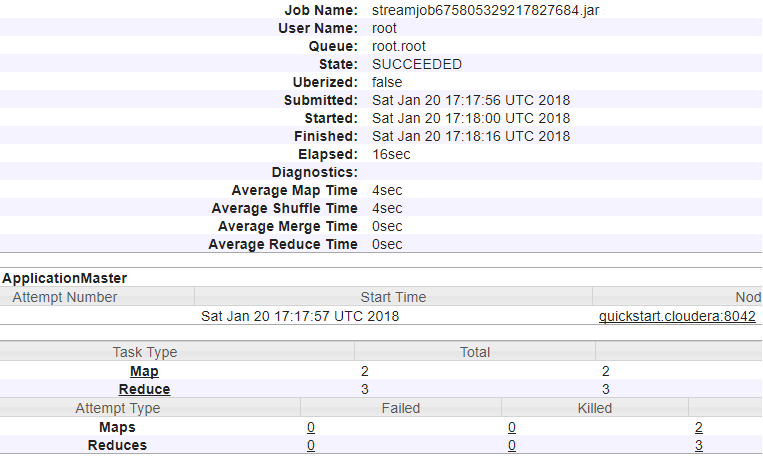

In [71]:
# part e - replace the image path in the code below to embed your UI screenshot
from IPython.display import Image
Image(filename="/media/notebooks/hw2q4screen.png")

# Question 5: Secondary Sort
In question 2 we talked a little bit about the default sorting that Hadoop observes. However often we'll want to sort not just by the key but also by value. For example, we might want to sort the words by their count to find the most frequent words but then break ties by the word in alphabetical order. This is called a 'secondary sort'. In this question we'll learn about specifying parameters for sorting in Hadoop jobs. In particular you'll add three new parameters to your Hadoop Streaming command:
> __`-D stream.num.map.output.key.fields=2`__ : tells Hadoop to treat both the first and the second (tab separated) fields as a composite key.  

> __`-D mapreduce.job.output.key.comparator.class=org.apache.hadoop.mapred.lib.KeyFieldBasedComparator`__ : tells Hadoop that we want to make comparisons (for sorting) based on the fields in this composite key

> __`-D mapreduce.partition.keycomparator.options="-k2,2nr -k1,1"`__: Tells Hadoop to perform a reverse numerical sort on the second field in the composite key and then break ties by sorting (alphabetically) on the first field in the composite key.

To find the top words in the _Alice in Wonderland_ text we'll use the output of our word counting job as the input for this new sorting task. Recall that this output is a file in alphabetical order whose lines are of the format `word \t count`. Also recall that this file is already available in HDFS at the path `{HDFS_DIR}/wordcount-output`. You can simply pass this directory path in to the Hadoop streaming input parameter and it will understand that it should read in the directory's contents. __`IMPORTANT`:__ _please use a single reduce task for parts a-c._

### Q5 Tasks:
* __a) short response:__ Before we get to the full secondary sort it's worth noting that there is a really easy way to get Hadoop to sort our file by count: we could just switch the order of the count and the word when we print to standard output in our mapper. Briefly explain why this would work.


* __b) code + short response:__ Complete the code in __`TopWords/mapper.py`__ so that it performs the switch described in 'a'. For debugging purposes we'll first run this job using a test file of word counts instead of the full _Alice_ file. Run the provided Hadoop streaming command to confirm that our sneaky solution works. Do you see any problems with the result?


* __c) code:__ Ok, for obvious reasons our 'sneaky' solution didn't quite give us the output we wanted. So let's do a secondary sort properly this time. Then add the three new Hadoop options described in the intro to this question. Run your job with these new specifications on the dummy count file. When you are satisfied that your job works, change the input path to specify the alice count output that is already in HDFS. Your list of top words should match the result you got in HW1. __`Two important warnings:`__  1) Parameters starting with the `-D` flag must come immediately after the line where you specify the jar file and before the parameters `-files`, `-mapper`, etc; 2) The options we provided you above specify a reverse numeric sort on the second field and tie breaking using the first field... but the mapper you wrote in part a switched the order of the words and the counts. You will need to make a small adjustment to the options we provided so that it instead reverse numerically sorts by the first field and breaks ties on the second. 


* __d) code + short response:__ Run your Hadoop job one more time but this time add the parameter to specify that the job should use 2 reduce tasks instead of 1. For convenience of illustration, you should do this using the sample counts file instead of the full _Alice_ text. What is wrong with the results? Use the provided code to look at the output of each partition independently. Can you explain why our results are off? Imagine we had a really large file and performed a sort using 100 partitions, what post processing would we have to do to get a fully ordered list (Total Order Sort)? Compare the computational cost of this postprocessing to the postprocessing we had to do in the VocabSize job.

### Q5 Student Answers:
> __a)__ Type your answer here!

> __b)__ Type your answer here!
 
> __d)__ Type your answer here!

__`NOTE:`__ The cell below will create a short file of word counts that we can load into HDFS and use to test our Hadoop MapReduce job. Take a moment to read this sample file and figure out what a reverse numerical sort (with alphabetical tie breaking) should yield. Then go on to complete your tasks as described above.

In [ ]:
%%writefile TopWords/sample.txt
foo	5
quux	9
labs	100
bar	5
qi	1

In [ ]:
# load sample file into HDFS (RUN THIS CELL AS IS)
!hdfs dfs -copyFromLocal TopWords/sample.txt {HDFS_DIR}

Your work for b-d starts here:

In [ ]:
# part b - complete your work in TopWords/mapper.py then RUN THIS CELL AS IS
!chmod a+x TopWords/mapper.py

In [ ]:
# parts b/c/d - clear output directory (RUN THIS CELL AS IS)
!hdfs dfs -rm -r {HDFS_DIR}/topwords-output

In [ ]:
# part b/c/d - Hadoop streaming command
!hadoop jar {JAR_FILE} \
  -files TopWords/mapper.py \
  -mapper mapper.py \
  -reducer /bin/cat \
  -input {HDFS_DIR}/sample.txt \
  -output {HDFS_DIR}/topwords-output

In [ ]:
# part b/c/d - Save results locally (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/topwords-output/part-0000* > TopWords/results.txt

In [ ]:
# part b/c/d - view results (RUN THIS CELL AS IS)
!head TopWords/results.txt

In [ ]:
# part d - look at first partition (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/topwords-output/part-00000

In [ ]:
# part d - look at second partition (RUN THIS CELL AS IS)
!hdfs dfs -cat {HDFS_DIR}/topwords-output/part-00001

# One last part 1 task...
You've now seen most of the basic functionality of writing and running Hadoop streaming jobs. In Part 2 and over the course of the next few weeks we'll explore additional options and tricks to add to our jobs. As we do this you will want to be able to quickly distinguish between errors that occur due to a mistake in your algorithm design or Hadoop streaming command and errors that are rooted in your Python code. Unfortunaly the error logs printed to console do not always make this distinction obvious. Luckily, the Hadoop UI logs do make it very easy to identify Python coding errors. Before you move on to part 2 we'd like to make sure you know where to find these logs and how to fix two common mistakes. __Below, we provided code that contains two common errors for you to debug. Your job is to:__
1. __Run the provided code as is, it will throw an error.__

2. __Navigate to the Hadoop UI and find the relevant logs explaining your error.__ 
 * Under `Task Type`, click `Map` > `task_XXXXXX` >`logs`

3. __Take a screenshot of the error description and embed it below.__

4. __Fix the error(s) and re-run the job__. 

__`NOTE:`__ There are two differet kinds of errors in the mapper code. See the inline comments for specific fixes: one involves adding a parameter to your Hadoop job the other two you must fix in the mapper code (re-run that cell to overwrite the old mapper). I'd recommend fixing them one at a time so that you can see how the logs and error messages change depending on the type of error.

In [ ]:
# run the following cells to create the demo mapper
!mkdir demo

In [ ]:
%%writefile demo/mapper.py
#!/usr/bin/env python
"""
This is a silly mapper to demonstrate some errors.
"""
import sys
import numpy as np  # To use numpy add -cmdenv PATH={PATH} to your Hadoop Job

for line in sys.stdin:
    msg = ("a message"   # missing a parenthesis here
    print 1/0            # dividing by zero is a no-go

In [ ]:
# clear HDFS output directory when you re-run the job
!hdfs dfs -rm -r {HDFS_DIR}/demo-output

In [ ]:
# Hadoop streaming command
!hadoop jar {JAR_FILE} \
  -files demo/mapper.py \
  -mapper mapper.py \
  -reducer /bin/cat \
  -input {HDFS_DIR}/sample.txt \
  -output {HDFS_DIR}/demo-output

In [ ]:
# embed your Hadoop UI error logs screenshot here
from IPython.display import Image
Image(filename="/media/notebooks/screenshot1.png")

In [ ]:
# embed your Hadoop UI error logs screenshot here
from IPython.display import Image
Image(filename="/media/notebooks/screenshot2.png")

# Part 1 ends here, continue on to part 2 in the notebook provided.